# Features

## imports

In [3]:
# ipython
import IPython
import IPython.display as ipydisp

# numpy
import numpy as np

# matplotlib
import matplotlib
matplotlib.use('gtkagg')
import matplotlib.pyplot as plt

# skimage
import skimage
import skimage.io
from skimage import data
from skimage import transform as tf
from skimage.feature import (match_descriptors, corner_harris, corner_peaks, ORB, plot_matches)
from skimage.color import rgb2gray


In [7]:
%matplotlib inline

## ORB

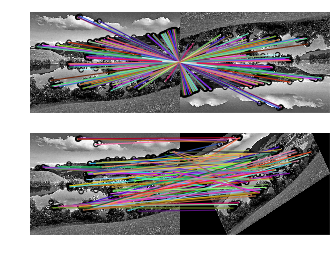

In [8]:
#img1 = rgb2gray(data.astronaut())
img1 = rgb2gray(skimage.io.imread('data/1413794251.jpg'))
img2 = tf.rotate(img1, 180)
tform = tf.AffineTransform(scale=(1.3, 1.1), rotation=0.5,
                           translation=(0, -200))
img3 = tf.warp(img1, tform)

descriptor_extractor = ORB(n_keypoints=200)

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img3)
keypoints3 = descriptor_extractor.keypoints
descriptors3 = descriptor_extractor.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
matches13 = match_descriptors(descriptors1, descriptors3, cross_check=True)

fig, ax = plt.subplots(nrows=2, ncols=1)

plt.gray()

plot_matches(ax[0], img1, img2, keypoints1, keypoints2, matches12)
ax[0].axis('off')

plot_matches(ax[1], img1, img3, keypoints1, keypoints3, matches13)
ax[1].axis('off')

plt.show()

In [14]:
descriptors1.shape

(200, 256)